Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # covariance matrix before training
    X = model(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return D, V, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	total loss: 0.046
iteration 1	total loss: 0.029
iteration 2	total loss: 0.021
iteration 3	total loss: 0.015
iteration 4	total loss: 0.012
iteration 5	total loss: 0.010
iteration 6	total loss: 0.008
iteration 7	total loss: 0.007
iteration 8	total loss: 0.006
iteration 9	total loss: 0.005
iteration 10	total loss: 0.004
iteration 11	total loss: 0.004
iteration 12	total loss: 0.003
iteration 13	total loss: 0.003
iteration 14	total loss: 0.003
iteration 15	total loss: 0.003
iteration 16	total loss: 0.002
iteration 17	total loss: 0.002
iteration 18	total loss: 0.002
iteration 19	total loss: 0.002
iteration 20	total loss: 0.002
iteration 21	total loss: 0.002
iteration 22	total loss: 0.001
iteration 23	total loss: 0.001
iteration 24	total loss: 0.001
iteration 25	total loss: 0.001
iteration 26	total loss: 0.001
iteration 27	total loss: 0.001
iteration 28	total loss: 0.001
iteration 29	total loss: 0.001
iteration 30	total loss: 0.001
iteration 31	total loss: 0.001
iteration 32	total

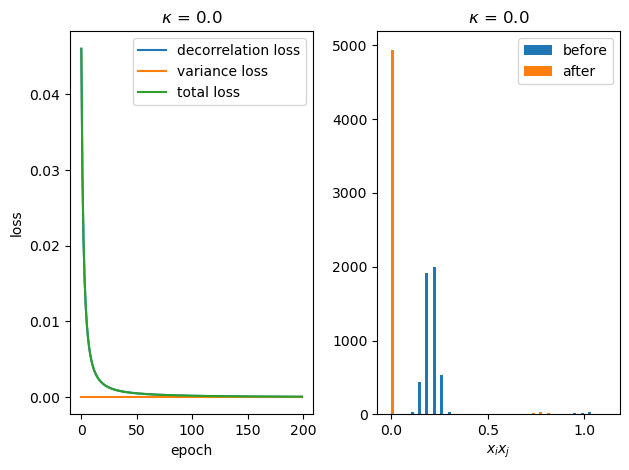

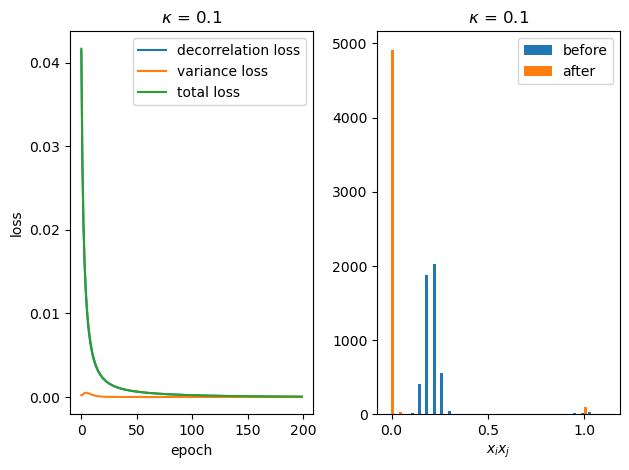

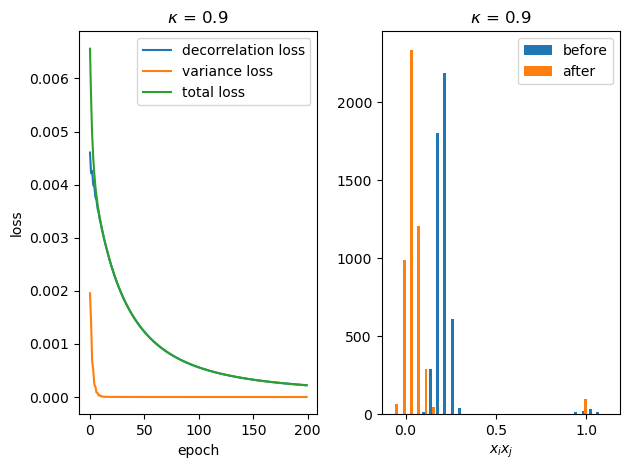

In [3]:
num_samples=1000
num_features=100
num_epochs=200
kappas = [0.0, 0.1, 0.9]
# ensure that we are at the same scale of the original lr
orig_lr=1e-2
lr = orig_lr * (num_features *  (num_features-1)) / 4

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

for kappa in kappas:

    # create a decorrelator
    model = Decorrelation(dim=num_features, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

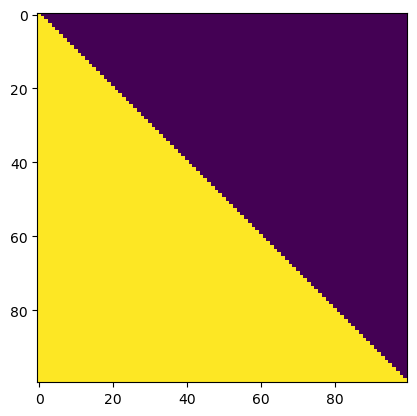

In [4]:
# we learn a lower triangular matrix
plt.imshow(model.R.detach().numpy() != 0);

Decorrelation of correlated input using DecorConv2d

iteration 0	total loss: 0.956
iteration 1	total loss: 0.455
iteration 2	total loss: 0.356
iteration 3	total loss: 0.344
iteration 4	total loss: 0.176
iteration 5	total loss: 0.234
iteration 6	total loss: 0.126
iteration 7	total loss: 0.163
iteration 8	total loss: 0.207
iteration 9	total loss: 0.117
iteration 10	total loss: 0.115
iteration 11	total loss: 0.092
iteration 12	total loss: 0.072
iteration 13	total loss: 0.065
iteration 14	total loss: 0.077
iteration 15	total loss: 0.060
iteration 16	total loss: 0.080
iteration 17	total loss: 0.052
iteration 18	total loss: 0.058
iteration 19	total loss: 0.041
iteration 20	total loss: 0.053
iteration 21	total loss: 0.031
iteration 22	total loss: 0.036
iteration 23	total loss: 0.063
iteration 24	total loss: 0.031
iteration 25	total loss: 0.039
iteration 26	total loss: 0.018
iteration 27	total loss: 0.029
iteration 28	total loss: 0.029
iteration 29	total loss: 0.016
iteration 30	total loss: 0.026
iteration 31	total loss: 0.024
iteration 32	total

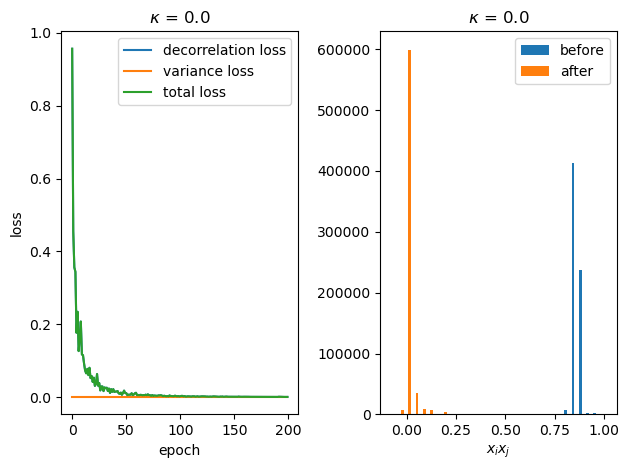

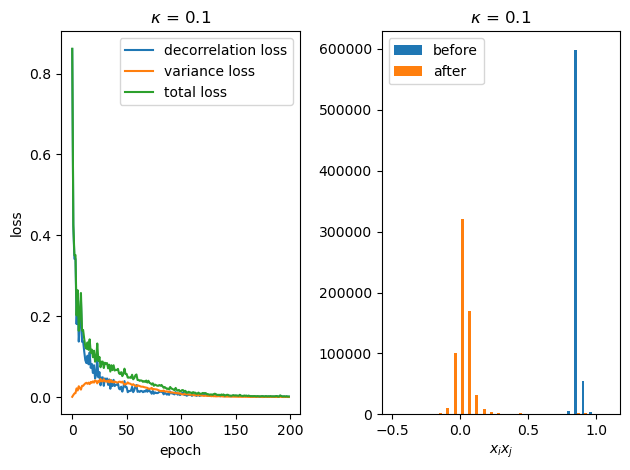

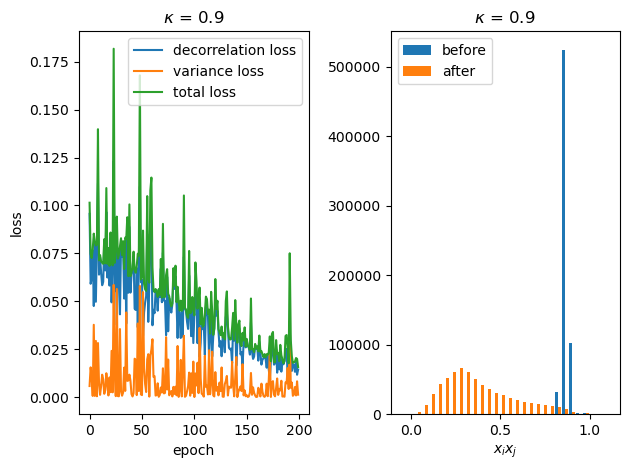

In [5]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
kappas = [0.0, 0.1, 0.9]
seed = 42
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

# ensure that we are at the same scale of the original lr
orig_lr=1e-2 # If we decrease lr (e.g. 1e-3) then things become less stable...?
lr = orig_lr * (size *  (size-1)) / 4

for kappa in kappas:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
    data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

    # create a convolutional decorrelator
    model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa, downsample_perc=downsample_perc)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

In [6]:
# WHEN IT WORKS WE CAN START TO COMBINE WITH A PATCHWISE MODEL

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison